In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import os

In [2]:
data = pd.read_csv('data/data_reduced.csv')
# data = pd.read_csv('data/data_reduced.csv')

In [3]:
def select_columns_elasticity(data):
    xE = data.drop(['blendE','blendSTRENGTH','blendStrainbreak', 'blendImpact', 'impurityImpact', 'impuritySTRENGTH', 'impurityStrainbreak', 'matrixImpact', 'matrixSTRENGTH', 'matrixStrainbreak'], axis=1)
    yE = data[['blendE']]
    return xE, yE
#     xE = data.drop(['blendSTRENGTH','blendStrainbreak', 'blendImpact', 'impurityImpact', 'impuritySTRENGTH', 'impurityStrainbreak', 'matrixImpact', 'matrixSTRENGTH', 'matrixStrainbreak'], axis=1)
#     return xE

class PreprocessTypePlastic:
    def transform(self, X):
        encoded = pd.get_dummies(X, columns=['MinorityPolymer'])
        encoded = encoded.drop('MajorityPolymer', axis=1)
        return encoded

    def fit(self, X, y=None):
        return self

# def preprocess_type_plastic(data):
#     encoded = pd.get_dummies(data, columns = ['MinorityPolymer'])
#     encoded = encoded.drop('MajorityPolymer', axis =1)
#     return data
    



[1.92849064e-02 3.53276552e-02 7.51811188e-03 8.05872742e-03
 1.40365152e-04 8.67444489e-03 2.21667263e-03 1.29180594e-03
 5.93126848e-04 7.75811391e-03 2.43920540e-03 1.61794728e-03
 6.90401850e-02 7.16140195e-01 2.33360372e-02 6.16664736e-02
 1.25902546e-02 1.64871316e-03 1.03503868e-04 4.06518648e-05
 5.48777416e-05 1.07226242e-04 4.91809591e-04 3.19791687e-04
 2.64658043e-05 1.47577978e-02 2.16616769e-04 3.73037975e-04
 2.18625457e-03 5.83408958e-04 2.23807473e-04 1.97225595e-04
 3.78676299e-04 5.76572750e-05 1.52594498e-05 5.20034093e-04
 2.95586139e-06]
   Contaminant_LCB  Contaminant_topology  MinorityPolymer_LDPE1   
0        -0.000184             -0.000765              -0.000234  \
1         0.000314              0.000357               0.000113   
2        -0.001466             -0.000726              -0.000847   
3        -0.002083             -0.001186              -0.002457   
4         0.000190              0.000110              -0.000057   
5         0.000431              

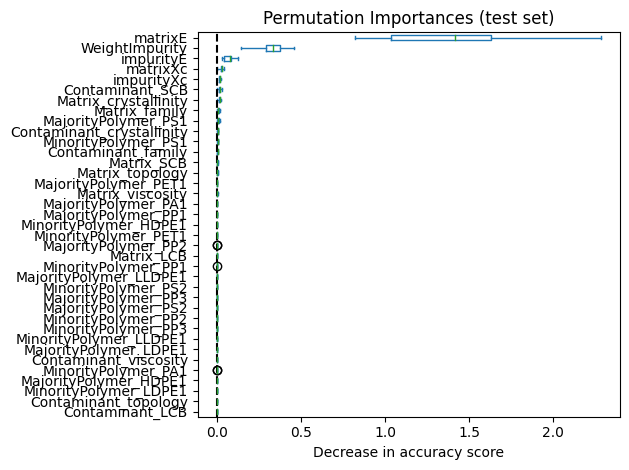

In [7]:
xE, yE = select_columns_elasticity(data)
X_train, X_test, y_train, y_test = train_test_split(xE, yE, test_size = 0.1, random_state = 0)
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.flatten())

print(rf.feature_importances_)

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=xE.columns[sorted_importances_idx],
)
print(importances)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.figure.show()


In [8]:
sorted_importances_idx.size
# xE.columns.size

37

In [9]:
n= sorted_importances_idx.size
fsRFPermutation = xE.columns[sorted_importances_idx[n-10:n]]
# reversing order 
fsRFPermutation = fsRFPermutation[n:None:-1]


In [10]:
fsRFPermutation[n:None:-1]

Index(['Contaminant_crystallinity', 'MajorityPolymer_PS1', 'Matrix_family',
       'Matrix_crystallinity', 'Contaminant_SCB', 'impurityXc', 'matrixXc',
       'impurityE', 'WeightImpurity', 'matrixE'],
      dtype='object')

In [11]:
# return sorted in ascending odere!!
def fs_permutation_importance(x, y):
    X_train, X_test, y_train, y_test = train_test_split(xE, yE, test_size = 0.1, random_state = 0)  
    rf = RandomForestRegressor()

    # y_train = y_train.values.flatten()
    # Fit the model on the training data
    rf.fit(X_train, y_train.values.flatten())

    result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    return sorted_importances_idx, result


def get_best_t(x, sorted_idx, t):
    n= sorted_idx.size
#     print(n)
    fsRFPermutation_names = x.columns.values[sorted_idx[n-t:n]]
    # reversing order 
#     fsRFPermutation_names = fsRFPermutation[n:None:-1]
    
    fsRFPermutation_idx = sorted_idx[n-t:n]
#     print(fsRFPermutation_idx)
#     fsRFPermutation_idx = fsRFPermutation_idx[n:None:-1]
#     print(fsRFPermutation_idx)
    return fsRFPermutation_names, fsRFPermutation_idx

    
# assuming in order already and only best t     
def get_plot(result, xE, sorted_idx, title):
    importances = pd.DataFrame(
        result.importances[sorted_idx].T,
        columns=xE.columns.values[sorted_idx],
    )
#     print(importances)
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(title)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    ax.figure.show()

    

# comparing partitions


#### P vs NP 

In [12]:
P = pd.read_csv('data/data_reduced_p.csv')
NP = pd.read_csv('data/data_reduced_np.csv')

In [13]:
xPE = P.drop(['blendE','blendSTRENGTH','blendStrainbreak', 'blendImpact', 'impurityImpact', 'impuritySTRENGTH', 'impurityStrainbreak', 'matrixImpact', 'matrixSTRENGTH', 'matrixStrainbreak'], axis=1)
yPE = P[['blendE']]
xNPE = P.drop(['blendE','blendSTRENGTH','blendStrainbreak', 'blendImpact', 'impurityImpact', 'impuritySTRENGTH', 'impurityStrainbreak', 'matrixImpact', 'matrixSTRENGTH', 'matrixStrainbreak'], axis=1)
yNPE = P[['blendE']]
X_trainP, X_testP, y_trainP, y_testP = train_test_split(xPE, yPE, test_size = 0.1, random_state = 0)
X_trainNP, X_testNP, y_trainNP, y_testNP = train_test_split(xNPE, yNPE, test_size = 0.1, random_state = 0)

/tmp/ipykernel_114/507641472.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfP.fit(X_trainP, y_trainP)


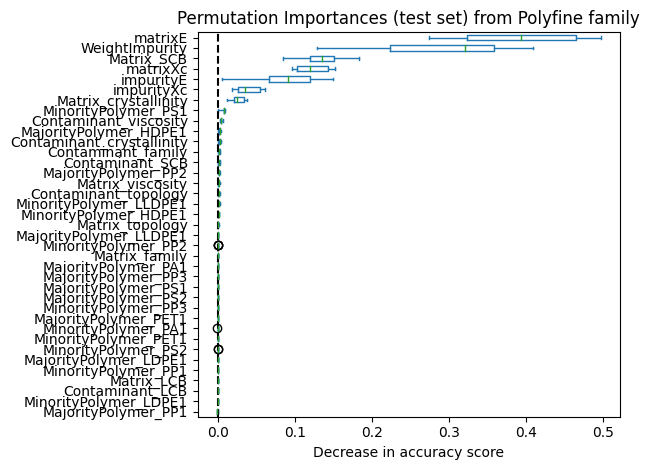

In [14]:
rfP = RandomForestRegressor()

# y_train = y_train.values.flatten()
# Fit the model on the training data
rfP.fit(X_trainP, y_trainP)
# print(rfP.feature_importances_)

resultP = permutation_importance(
    rfP, X_testP, y_testP, n_repeats=10, random_state=0, n_jobs=2
)

sorted_importances_idxP = resultP.importances_mean.argsort()
importancesP = pd.DataFrame(
    resultP.importances[sorted_importances_idxP].T,
    columns=xPE.columns[sorted_importances_idxP],
)
# print(importancesP)
ax = importancesP.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) from Polyfine family")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.figure.show()


In [15]:
# taking best 10 features 
nP= sorted_importances_idxP.size
fsRFPermutationP = xPE.columns[sorted_importances_idxP[nP-10:nP]]
# reversing order 
fsRFPermutationP = fsRFPermutationP[nP:None:-1]
fsRFPermutationP

Index(['matrixE', 'WeightImpurity', 'Matrix_SCB', 'matrixXc', 'impurityE',
       'impurityXc', 'Matrix_crystallinity', 'MinorityPolymer_PS1',
       'Contaminant_viscosity', 'MajorityPolymer_HDPE1'],
      dtype='object')

/tmp/ipykernel_114/153693494.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfNP.fit(X_trainNP, y_trainNP)


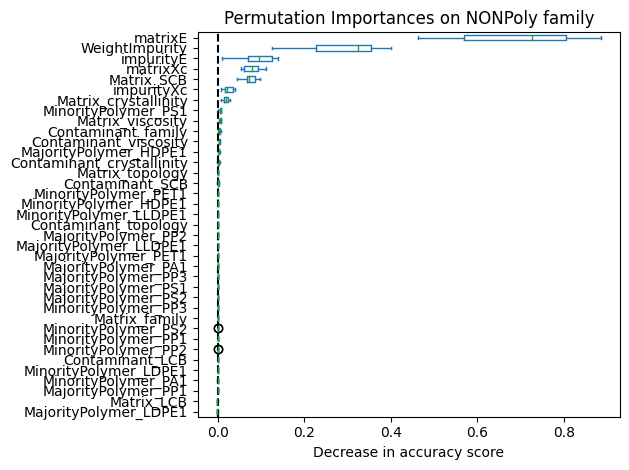

In [16]:
rfNP = RandomForestRegressor()

# y_train = y_train.values.flatten()
# Fit the model on the training data
rfNP.fit(X_trainNP, y_trainNP)
# print(rfNP.feature_importances_)

resultNP = permutation_importance(
    rfNP, X_testNP, y_testNP, n_repeats=10, random_state=0, n_jobs=2
)

sorted_importances_idxNP = resultNP.importances_mean.argsort()
importancesNP = pd.DataFrame(
    resultNP.importances[sorted_importances_idxNP].T,
    columns=xNPE.columns[sorted_importances_idxNP],
)
# print(importancesNP)
ax = importancesNP.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances on NONPoly family")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.figure.show()



In [17]:
nNP= sorted_importances_idxNP.size
fsRFPermutationNP = xNPE.columns[sorted_importances_idxNP[nNP-10:nNP]]
# reversing order 
fsRFPermutationNP = fsRFPermutationNP[nNP:None:-1]
fsRFPermutationNP

Index(['matrixE', 'WeightImpurity', 'impurityE', 'matrixXc', 'Matrix_SCB',
       'impurityXc', 'Matrix_crystallinity', 'MinorityPolymer_PS1',
       'Matrix_viscosity', 'Contaminant_family'],
      dtype='object')

### Matrix Topology 

In [15]:

branched = pd.read_csv('data/data_reduced_branched_topo.csv')
linear = pd.read_csv('data/data_reduced_linear_topo.csv')
branched.drop('Matrix_topology', axis=1)
linear.drop('Matrix_topology', axis=1)
xBTE, yBTE = select_columns_elasticity(branched)
xLTE, yLTE = select_columns_elasticity(linear)
# tehy have polymers already 1hot enconded

fsRFPermutationBT, resultB= fs_permutation_importance(xBTE, yBTE)
fsRFPermutationLT, resultL = fs_permutation_importance(xLTE, yLTE)

# getting 10 best features 
fsRFPermutationBT_names, fsRFPermutationBT_idx = get_best_t(x= xBTE, sorted_idx= fsRFPermutationBT, t= 10 )
fsRFPermutationLT_names, fsRFPermutationLT_idx = get_best_t(x= xLTE, sorted_idx= fsRFPermutationLT, t= 10 )
# print(fsRFPermutationBT_idx)

get_plot(result=resultB, xE=xBTE, sorted_idx= fsRFPermutationBT_idx, title= "Permutation Importances Branched Topology")
get_plot(result= resultL, xE=xLTE, sorted_idx= fsRFPermutationLT_idx, title= "Permutation Importances Linear Topology")


In [16]:
xLTE.columns.values[1:10]

### Matrix Crystalinity

In [ ]:
high = pd.read_csv('data/data_reduced_high_crys.csv')
low = pd.read_csv('data/data_reduced_low_crys.csv')
amorp=  pd.read_csv('data/data_reduced_amorp_crys.csv')
high.drop('Matrix_crystallinity', axis=1)
low.drop('Matrix_crystallinity', axis=1)
amorp.drop('Matrix_crystallinity', axis=1)

xHCE, yHCE = select_columns_elasticity(high)
xLCE, yLCE = select_columns_elasticity(low)
xACE, yACE = select_columns_elasticity(amorp)


In [ ]:
fsRFPermutationHC, resultHC= fs_permutation_importance(xHCE, yHCE)
fsRFPermutationLC, resultLC = fs_permutation_importance(xLCE, yLCE)
fsRFPermutationAC, resultAC = fs_permutation_importance(xACE, yACE)
# getting 10 best features 
fsRFPermutationHC_names, fsRFPermutationHC_idx = get_best_t(x= xHCE, sorted_idx= fsRFPermutationHC, t= 10 )
fsRFPermutationLC_names, fsRFPermutationLC_idx = get_best_t(x= xLCE, sorted_idx= fsRFPermutationLC, t= 10 )
fsRFPermutationAC_names, fsRFPermutationAC_idx = get_best_t(x= xACE, sorted_idx= fsRFPermutationAC, t= 10 )

get_plot(result=resultHC, xE=xHCE, sorted_idx= fsRFPermutationHC_idx, title= "Permutation Importances High Crystalinity")
get_plot(result= resultLC, xE=xLCE, sorted_idx= fsRFPermutationLC_idx, title= "Permutation Importances Low Crystalinity")
get_plot(result=resultAC, xE=xACE, sorted_idx= fsRFPermutationAC_idx, title= "Permutation Importances amorphous Crystalinity")


### Polymer Matrix type

In [ ]:
HDPE = pd.read_csv('data/datadata_reduced_hdpe.csv')
LDPE = pd.read_csv('data/datadata_reduced_ldpe.csv')
LLDPE = pd.read_csv('data/datadata_reduced_lldpe.csv')
PET = pd.read_csv('data/datadata_reduced_pet.csv')
PS1 = pd.read_csv('data/datadata_reduced_ps1.csv')
PS2 = pd.read_csv('data/datadata_reduced_ps2.csv')
PP1 = pd.read_csv('data/datadata_reduced_pp1.csv')
PP2 = pd.read_csv('data/datadata_reduced_pp2.csv')
PP3 = pd.read_csv('data/datadata_reduced_pp3.csv')
PA = pd.read_csv('data/datadata_reduced_pa.csv')

In [ ]:
PA.columns.values

### trying to automate with pipeline

In [ ]:
# def permutation_feature_plastic(data):
#     data=(
#         data
#         .pipe(preprocess_type_plastic)
#         .pipe(select_columns_elasticity)
#     )
    
pipeline1 = Pipeline([
    ('plastics',preprocess_type_plastic),
    ('elasticity',select_columns_elasticity)
    
])

pipeline2 = Pipeline([
#     split data here and feed to RF
    ('rf', RandomForestRegressor()),
    ('permutation',fs_permutation_importance ),
    ('ten best', get_best_t)
    
])

X = pipeline1.fit_transform(data)
y = data['blendE']
best_features = pipeline2.fit_transform(X, y, permutation__t=10)

print("Best Features:")
print(best_features)

    

# gaussian


In [ ]:
# Fit the model to the toy data.
gpr = GaussianProcessRegressor()
gpr.fit(X_train, y_train)


# Perform interpolation prediction.
y_pred_train = gpr.predict(X_train)


# Perform extrapolation prediction. The model should
# not perform very well here.
y_pred = gpr.predict(X_test)


plt.plot(xE['matrixE'], yE, "k", linewidth = 6)
plt.plot(X_train, y_pred_train, "r")
plt.plot(X_test, y_pred, "b")
plt.legend(["Training data", "Interpolation", "Extrapolation"])
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()